# European OpenGHGMap 

# Setup
## Library import
We import all the required Python libraries

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.wkb 
from shapely.ops import cascaded_union
from shapely.geometry import Polygon, Point, MultiPolygon
from tqdm import tqdm

## Utils

**rtree_intersect**

In [28]:
def rtree_intersect(gdf_1, gdf_2, geo_name):
    fraction  = []
    name = []
    
    sindex = gdf_1.sindex
    # We iterate over municipalities in gdf_2   
    for n, municipality in enumerate(gdf_2.geometry):
        # Fix invalid shapes
        if municipality.is_valid == False:
            municipality = municipality.simplify(0.016, preserve_topology=True)
            if municipality.is_valid == False:
                municipality = cascaded_union(municipality)
            
        # gadm areas that intersect with the municipality bound
        possible_matches_index = list(sindex.intersection(municipality.bounds))
        possible_matches = gdf_1.iloc[possible_matches_index]

        frac  = []
        for i in range(len(possible_matches_index)):
            geom = possible_matches.geometry.iloc[i]
            # Intersection area
            int_area = geom.intersection(municipality).area
            # Residual area
            res_area = (geom.area - int_area) + (municipality.area - int_area)
            # Total area
            tot_area = int_area + res_area
    
            frac.append(int_area/tot_area)
    
        frac = np.array(frac)
        if frac.any():
            matches = possible_matches.iloc[np.where(frac == frac.max())]
            name.append(matches.get(geo_name).iloc[0])
            fraction.append(frac.max())
        else:
            name.append('')
            fraction.append(0)
    return name, fraction

**Read data**

# Data import

## Municipios de España

**[Data source](https://opendata.esri.es/datasets/53229f5912e04f1ba6dddb70a5abeb72_0/explore?location=43.017075%2C9.288571%2C5.20)**

In [3]:
municipios = gpd.read_file(f'../../datasets/raw/georegions/Municipios/Municipios_IGN.shp')
municipios.sort_values(['CODNUT1', 'CODNUT2', 'CODNUT3', 'CODIGOINE'], inplace = True)

Remove Canarias, Ceuta, and Melilla

In [4]:
municipios = municipios[~municipios['CODNUT2'].isin(['ES70', 'ES63', 'ES64'])]
municipios = municipios.reset_index(drop=True)

**Display geometries**

<AxesSubplot:>

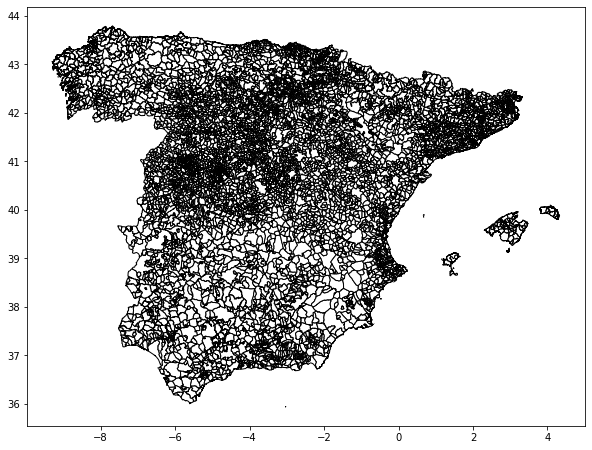

In [5]:
fig, ax = plt.subplots(figsize=(10,10))
municipios.plot(ax=ax, color='w', edgecolor='k')

## European OpenGHGMap 
**[Data source](https://openghgmap.net/data/)**

This project maps CO2 emissions across Europe. The aim is to estimate an emissions inventory for each of the ~116 000 administrative jurisdictions across Europe and the UK.

The model spatially disaggregates each country's official (Eurostat) CO2 emissions inventory to places using OpenStreetMap. Vehicle emissions are attributed across fuel stations, train emissions at stations, aviation bunker fuel emissions at airports, and so on. Industrial source emissions are located at the registered address where these emissions phyiscally occur or are legally controlled. Data are for the year 2018.

**Variables:**
- **Emissions:** 
The data are for the year 2018. Emissions are reported in units of metric tonnes (t) CO2.

**Read data**

In [10]:
gdf_ghg = gpd.read_file('../../datasets/raw/climate/data-OpenGHGMap/spain/8.geojson')

Remove Canarias, Ceuta, and Melilla

In [11]:
gdf_ghg = gdf_ghg[~gdf_ghg['rname'].isin(['Ceuta', 'Melilla'])]
gdf_ghg = gdf_ghg.reset_index(drop=True)

**Merge Polygons of duplicated rows into a MultiPolygon**

In [12]:
# Drop duplicates
duplicates = gdf_ghg.duplicated(subset=['rname', 'population_2015', 'co2', 'nrid'], keep=False)

gdf_unique = gdf_ghg[~duplicates].copy()

for n, name in enumerate(gdf_ghg[duplicates]['rname'].unique()):
    gdf_name = gdf_ghg[gdf_ghg['rname'] == name].copy()
    gdf_tmp = gdf_name.iloc[:1]
    gdf_tmp['geometry'] = MultiPolygon(list(gdf_name['geometry']))

    if n == 0:
        gdf_multi = gdf_tmp.copy()
    else:
        gdf_multi = pd.concat([gdf_multi, gdf_tmp])
   
gdf_ghg = pd.concat([gdf_unique, gdf_multi])
gdf_ghg.sort_values('nrid', inplace=True)
gdf_ghg.reset_index(drop=True, inplace=True)

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [13]:
gdf_ghg.head()

,categorized,rname,population_2015,co2,coname,coco2,nrid,geometry
0,"{'fuelstations': 6854, 'buildings': 1680}",A Arnoia,1038.871721,8534.0,spain,319762270.0,1,"POLYGON ((-8.11777 42.22533, -8.11844 42.22477..."
1,"{'fuelstations': 20562, 'buildings': 10500, 'f...",A Baña,3462.579152,31262.0,spain,319762270.0,2,"POLYGON ((-8.69229 42.92662, -8.69318 42.92694..."
2,{'buildings': 84},A Bola,1273.275046,84.0,spain,319762270.0,3,"POLYGON ((-7.89096 42.11237, -7.89809 42.11214..."
3,"{'fuelstations': 6854, 'buildings': 9828, 'far...",A Capela,1343.553445,17282.0,spain,319762270.0,4,"POLYGON ((-8.09923 43.46858, -8.09939 43.46837..."
4,"{'fuelstations': 34270, 'buildings': 4788}",A Cañiza,5124.547047,39058.0,spain,319762270.0,5,"POLYGON ((-8.22299 42.23325, -8.22326 42.22971..."


**Display data**

<AxesSubplot:>

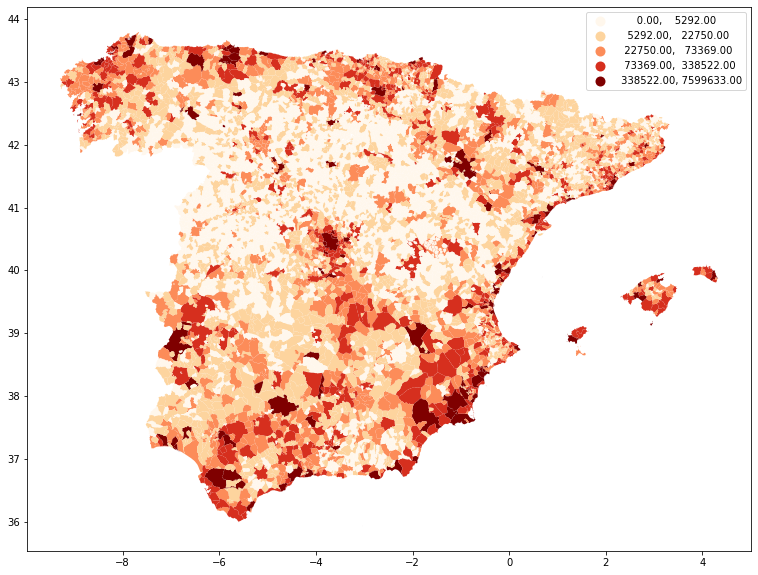

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))

gdf_ghg.plot(ax=ax, column='co2', cmap='OrRd', scheme='jenkscaspallsampled', legend=True)

### Overlap between OpenGHGMap and Instituto Geográfico Nacional (IGN) municipalities

In [15]:
gdf_ghg

,categorized,rname,population_2015,co2,coname,coco2,nrid,geometry
0,"{'fuelstations': 6854, 'buildings': 1680}",A Arnoia,1038.871721,8534.0,spain,319762270.0,1,"POLYGON ((-8.11777 42.22533, -8.11844 42.22477..."
1,"{'fuelstations': 20562, 'buildings': 10500, 'f...",A Baña,3462.579152,31262.0,spain,319762270.0,2,"POLYGON ((-8.69229 42.92662, -8.69318 42.92694..."
2,{'buildings': 84},A Bola,1273.275046,84.0,spain,319762270.0,3,"POLYGON ((-7.89096 42.11237, -7.89809 42.11214..."
3,"{'fuelstations': 6854, 'buildings': 9828, 'far...",A Capela,1343.553445,17282.0,spain,319762270.0,4,"POLYGON ((-8.09923 43.46858, -8.09939 43.46837..."
4,"{'fuelstations': 34270, 'buildings': 4788}",A Cañiza,5124.547047,39058.0,spain,319762270.0,5,"POLYGON ((-8.22299 42.23325, -8.22326 42.22971..."
...,...,...,...,...,...,...,...,...
8149,"{'buildings': 5460, 'farms': 1100}",Òrrius,621.055142,6560.0,spain,319762270.0,8152,"POLYGON ((2.33743 41.56121, 2.33817 41.55913, ..."
8150,"{'fuelstations': 6854, 'buildings': 2184, 'ets...",Ólvega,3591.163024,11659.0,spain,319762270.0,8153,"POLYGON ((-1.92681 41.71698, -1.91928 41.71904..."
8151,"{'fuelstations': 34270, 'buildings': 25788}",Órgiva,5485.714005,60058.0,spain,319762270.0,8154,"POLYGON ((-3.31769 36.82224, -3.31759 36.82295..."
8152,"{'fuelstations': 137080, 'trains': 636, 'build...",Úbeda,33354.580041,184116.0,spain,319762270.0,8155,"MULTIPOLYGON (((-3.40416 37.90798, -3.40008 37..."


In [16]:
municipios

,FID,INSPIREID,NATCODE,NAMEUNIT,CODNUT1,CODNUT2,CODNUT3,CODIGOINE,SHAPE_Leng,SHAPE_Area,geometry
0,7792,ES.IGN.SIGLIM34121515001,34121515001,Abegondo,ES1,ES11,ES111,15001,0.633565,0.009293,"POLYGON ((-8.35892 43.14721, -8.35864 43.14764..."
1,7793,ES.IGN.SIGLIM34121515002,34121515002,Ames,ES1,ES11,ES111,15002,0.757739,0.008821,"POLYGON ((-8.72471 42.88868, -8.72403 42.88872..."
2,7794,ES.IGN.SIGLIM34121515003,34121515003,Aranga,ES1,ES11,ES111,15003,0.653707,0.013249,"POLYGON ((-8.11605 43.21256, -8.11120 43.21299..."
3,7795,ES.IGN.SIGLIM34121515004,34121515004,Ares,ES1,ES11,ES111,15004,0.434604,0.002024,"MULTIPOLYGON (((-8.26941 43.42891, -8.26951 43..."
4,7796,ES.IGN.SIGLIM34121515005,34121515005,Arteixo,ES1,ES11,ES111,15005,0.671846,0.010410,"MULTIPOLYGON (((-8.55475 43.31382, -8.55483 43..."
...,...,...,...,...,...,...,...,...,...,...,...
8110,629,ES.IGN.SIGLIM34143030041,34143030041,La Unión,ES6,ES62,ES620,30041,0.293584,0.002608,"POLYGON ((-0.87089 37.57509, -0.87099 37.57610..."
8111,630,ES.IGN.SIGLIM34143030042,34143030042,Villanueva del Río Segura,ES6,ES62,ES620,30042,0.239119,0.001354,"POLYGON ((-1.33350 38.13457, -1.33294 38.13432..."
8112,631,ES.IGN.SIGLIM34143030043,34143030043,Yecla,ES6,ES62,ES620,30043,1.015005,0.062635,"POLYGON ((-1.34432 38.67705, -1.34407 38.67710..."
8113,632,ES.IGN.SIGLIM34143030901,34143030901,Santomera,ES6,ES62,ES620,30901,0.293271,0.004539,"POLYGON ((-1.10116 38.11349, -1.09939 38.11438..."


**Merge by name**

In [17]:
gdf = pd.merge(municipios[['NATCODE', 'NAMEUNIT', 'CODNUT1', 'CODNUT2', 'CODNUT3', 'CODIGOINE', 'geometry']], gdf_ghg[['categorized', 'rname', 'population_2015', 'co2', 'coco2']], how='left', left_on='NAMEUNIT', right_on='rname')
gdf

,NATCODE,NAMEUNIT,CODNUT1,CODNUT2,CODNUT3,CODIGOINE,geometry,categorized,rname,population_2015,co2,coco2
0,34121515001,Abegondo,ES1,ES11,ES111,15001,"POLYGON ((-8.35892 43.14721, -8.35864 43.14764...","{'fuelstations': 13708, 'buildings': 139440, '...",Abegondo,5476.444286,165448.0,319762270.0
1,34121515002,Ames,ES1,ES11,ES111,15002,"POLYGON ((-8.72471 42.88868, -8.72403 42.88872...","{'fuelstations': 13708, 'buildings': 28980, 'f...",Ames,26507.657375,43288.0,319762270.0
2,34121515003,Aranga,ES1,ES11,ES111,15003,"POLYGON ((-8.11605 43.21256, -8.11120 43.21299...","{'fuelstations': 6854, 'buildings': 56868, 'fa...",Aranga,1921.967197,64922.0,319762270.0
3,34121515004,Ares,ES1,ES11,ES111,15004,"MULTIPOLYGON (((-8.26941 43.42891, -8.26951 43...","{'buildings': 64512, 'farms': 20900}",Ares,3711.193989,85412.0,319762270.0
4,34121515005,Arteixo,ES1,ES11,ES111,15005,"MULTIPOLYGON (((-8.55475 43.31382, -8.55483 43...","{'fuelstations': 41124, 'buildings': 139692, '...",Arteixo,36073.030660,1117753.0,319762270.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8110,34143030041,La Unión,ES6,ES62,ES620,30041,"POLYGON ((-0.87089 37.57509, -0.87099 37.57610...","{'fuelstations': 20562, 'buildings': 5040, 'fa...",La Unión,19907.885135,26002.0,319762270.0
8111,34143030042,Villanueva del Río Segura,ES6,ES62,ES620,30042,"POLYGON ((-1.33350 38.13457, -1.33294 38.13432...",{'buildings': 1260},Villanueva del Río Segura,2548.204667,1260.0,319762270.0
8112,34143030043,Yecla,ES6,ES62,ES620,30043,"POLYGON ((-1.34432 38.67705, -1.34407 38.67710...","{'fuelstations': 82248, 'buildings': 40992, 'f...",Yecla,34677.447032,173540.0,319762270.0
8113,34143030901,Santomera,ES6,ES62,ES620,30901,"POLYGON ((-1.10116 38.11349, -1.09939 38.11438...","{'fuelstations': 47978, 'buildings': 15288, 'f...",Santomera,15369.155204,83266.0,319762270.0


Number of names that don't match

In [18]:
len(gdf[gdf['co2'].isnull()])

423

In [19]:
municipios_mismatch = gdf[gdf['co2'].isnull()]
municipios_mismatch.sort_values('NAMEUNIT')

,NATCODE,NAMEUNIT,CODNUT1,CODNUT2,CODNUT3,CODIGOINE,geometry,categorized,rname,population_2015,co2,coco2
751,34153131003,Abaurregaina/Abaurrea Alta,ES2,ES22,ES220,31003,"POLYGON ((-1.23519 42.86717, -1.23592 42.86920...",NaN,NaN,NaN,NaN,NaN
752,34153131004,Abaurrepea/Abaurrea Baja,ES2,ES22,ES220,31004,"POLYGON ((-1.24548 42.88875, -1.24523 42.88982...",NaN,NaN,NaN,NaN,NaN
750,34153131002,Abárzuza/Abartzuza,ES2,ES22,ES220,31002,"POLYGON ((-2.07371 42.75426, -2.07370 42.75536...",NaN,NaN,NaN,NaN,NaN
1418,34024444004,Aguaviva,ES2,ES24,ES242,44004,"POLYGON ((-0.26625 40.82049, -0.26541 40.82045...",NaN,NaN,NaN,NaN,NaN
530,34160101051,Agurain/Salvatierra,ES2,ES21,ES211,01051,"MULTIPOLYGON (((-2.42773 42.85725, -2.42838 42...",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
6785,34100303105,el Pinós/Pinoso,ES5,ES52,ES521,03105,"POLYGON ((-1.09416 38.43793, -1.09365 38.43807...",NaN,NaN,NaN,NaN,NaN
7084,34104646127,la Font d'En Carròs,ES5,ES52,ES523,46127,"POLYGON ((-0.18426 38.92588, -0.18342 38.92643...",NaN,NaN,NaN,NaN,NaN
6889,34101212075,la Mata de Morella,ES5,ES52,ES522,12075,"POLYGON ((-0.29913 40.61292, -0.29867 40.61340...",NaN,NaN,NaN,NaN,NaN
6932,34101212119,la Torre d'En Besora,ES5,ES52,ES522,12119,"POLYGON ((-0.08327 40.33430, -0.08300 40.33411...",NaN,NaN,NaN,NaN,NaN


In [20]:
gdf_ghg_mismatch = gdf_ghg[~gdf_ghg['rname'].isin(list(gdf[~gdf['co2'].isnull()]['rname']))]
gdf_ghg_mismatch.sort_values('rname')

,categorized,rname,population_2015,co2,coname,coco2,nrid,geometry
36,{'buildings': 3948},AbaurregainaAbaurrea Alta,140.158821,3948.0,spain,319762270.0,37,"POLYGON ((-1.19906 42.88779, -1.19895 42.88813..."
37,{'buildings': 1932},AbaurrepeaAbaurrea Baja,30.842200,1932.0,spain,319762270.0,38,"POLYGON ((-1.24418 42.87530, -1.24362 42.87386..."
59,{'buildings': 2688},AbárzuzaAbartzuza,530.556862,2688.0,spain,319762270.0,60,"POLYGON ((-2.04765 42.73928, -2.04596 42.73675..."
93,"{'fuelstations': 6854, 'buildings': 84}",Aguaviva Aiguaviva de Bergantes,808.639879,6938.0,spain,319762270.0,94,"POLYGON ((-0.19718 40.78445, -0.19722 40.78484..."
107,"{'fuelstations': 13708, 'trains': 318, 'buildi...",AgurainSalvatierra,3944.678193,61198.0,spain,319762270.0,108,"MULTIPOLYGON (((-2.33216 42.81742, -2.33173 42..."
...,...,...,...,...,...,...,...,...
8128,"{'fuelstations': 6854, 'buildings': 12096}",les Preses,3743.735820,18950.0,spain,319762270.0,8131,"POLYGON ((2.48492 42.13627, 2.49194 42.13500, ..."
8129,{'buildings': 5376},les Useres Useras,1038.300956,5376.0,spain,319762270.0,8132,"POLYGON ((-0.18561 40.14119, -0.18475 40.14166..."
8130,"{'buildings': 5292, 'farms': 200}",les Valls d'Aguilar,301.343695,5492.0,spain,319762270.0,8133,"POLYGON ((1.21037 42.36030, 1.20987 42.35902, ..."
8131,{'buildings': 9492},les Valls de Valira,1098.611000,9492.0,spain,319762270.0,8134,"MULTIPOLYGON (((1.60099 42.42456, 1.59003 42.4..."


<AxesSubplot:>

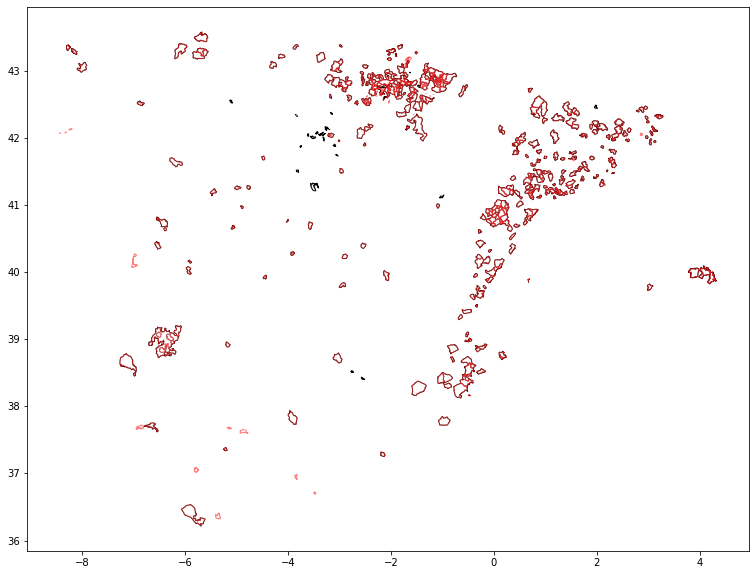

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))

municipios_mismatch.plot(ax=ax, color='w', edgecolor='k')
gdf_ghg_mismatch .plot(ax=ax, color='w', edgecolor='r', alpha=0.5)

**Get overlapping geometries**

Make sure all the geometries are valid

In [22]:
s = gdf_ghg_mismatch.geometry
gdf_ghg_mismatch[~s.is_valid]

,categorized,rname,population_2015,co2,coname,coco2,nrid,geometry
996,"{'fuelstations': 0, 'buildings': 0, 'farms': 0...",Bela,38.809663,0.0,spain,319762270.0,997,"POLYGON ((-8.42141 42.07136, -8.42153 42.07284..."
2397,"{'fuelstations': 116518, 'trains': 3816, 'buil...",DonostiaSan Sebastián,179677.765647,604135.0,spain,319762270.0,2399,"MULTIPOLYGON (((-2.03274 43.27147, -2.03310 43..."
3834,{'buildings': 420},"Ledanía de Castrillo de la Reina, Hacinas, Mon...",40.931927,420.0,spain,319762270.0,3836,"MULTIPOLYGON (((-3.10656 42.05740, -3.10972 42..."
3924,{'buildings': 3444},Llocnou d'en Fenollet,930.997465,3444.0,spain,319762270.0,3926,"MULTIPOLYGON (((-0.47331 39.00758, -0.47282 39..."
4052,"{'buildings': 5712, 'farms': 100}",LónguidaLongida,2883.592276,5812.0,spain,319762270.0,4054,"MULTIPOLYGON (((-1.43988 42.76707, -1.43776 42..."
4669,"{'fuelstations': 116518, 'trains': 318, 'build...",Mérida_1,34869.585119,139012.0,spain,319762270.0,4672,"MULTIPOLYGON (((-6.57425 39.15836, -6.57731 39..."
5175,{'farms': 200},Penamacor,0.000000,200.0,spain,319762270.0,5178,"POLYGON ((-6.98889 40.27821, -6.98884 40.27820..."
6073,"{'fuelstations': 34270, 'buildings': 1596}",Sancti-Spíritus_1,814.349841,35866.0,spain,319762270.0,6076,"MULTIPOLYGON (((-6.34436 40.73298, -6.34539 40..."
7955,"{'fuelstations': 6854, 'buildings': 13356, 'fa...",el Genovés,3467.661104,22210.0,spain,319762270.0,7958,"MULTIPOLYGON (((-0.47343 39.00450, -0.47334 39..."
7998,{'buildings': 3696},es Bòrdes,245.108837,3696.0,spain,319762270.0,8001,"POLYGON ((0.68009 42.72344, 0.68036 42.72344, ..."


In [23]:
gdf_ghg_mismatch_invalid = gdf_ghg_mismatch[~s.is_valid]
gdf_ghg_mismatch_invalid['geometry'] = gdf_ghg_mismatch_invalid['geometry'].apply(lambda x: x.buffer(1e-5))

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [24]:
for index in list(gdf_ghg_mismatch_invalid.index):
    gdf_ghg_mismatch.at[index, 'geometry'] = gdf_ghg_mismatch_invalid.loc[index]['geometry']

In [25]:
gdf_ghg_mismatch_invalid.geometry.is_valid.all()

True

In [26]:
gdf_ghg_mismatch.geometry.is_valid.all()

True

In [29]:
name, fraction = rtree_intersect(gdf_ghg_mismatch, municipios_mismatch, geo_name='rname')

In [30]:
municipios_mismatch['rname'] = name
municipios_mismatch['match_fraction'] = fraction
municipios_mismatch.drop(columns=['categorized', 'population_2015', 'co2', 'coco2'], inplace=True)

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [31]:
municipios_mismatch

,NATCODE,NAMEUNIT,CODNUT1,CODNUT2,CODNUT3,CODIGOINE,geometry,rname,match_fraction
61,34121515064,Paderne,ES1,ES11,ES111,15064,"POLYGON ((-8.21699 43.29995, -8.21582 43.30239...",Paderne_1,0.986877
72,34121515075,Sada,ES1,ES11,ES111,15075,"MULTIPOLYGON (((-8.29745 43.38672, -8.29739 43...",Sada_1,0.988642
77,34121515080,Sobrado,ES1,ES11,ES111,15080,"POLYGON ((-8.10205 43.04224, -8.10158 43.04250...",Sobrado_2,0.991750
336,34033333024,Gijón,ES1,ES12,ES120,33024,"MULTIPOLYGON (((-5.59767 43.54894, -5.59777 43...",GijónXixón,0.978956
338,34033333026,Grado,ES1,ES12,ES120,33026,"POLYGON ((-6.20021 43.18357, -6.20121 43.18560...",GrauGrado,0.977637
...,...,...,...,...,...,...,...,...,...
7842,34012323086,Torredelcampo,ES6,ES61,ES616,23086,"POLYGON ((-4.00020 37.87851, -4.00002 37.87868...",Torre del Campo,0.999972
7861,34012353050,Cuarto del Madroño,ES6,ES61,ES616,53050,"POLYGON ((-2.77889 38.51067, -2.77863 38.51184...",,0.000000
8016,34014141052,Lantejuela,ES6,ES61,ES618,41052,"POLYGON ((-5.25625 37.35593, -5.25543 37.35819...",La Lantejuela,0.999500
8088,34143030019,Cieza,ES6,ES62,ES620,30019,"POLYGON ((-1.58954 38.30999, -1.58282 38.31347...",Cieza_1,0.999977


**Distribution of the accuracy**

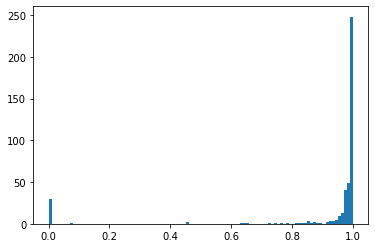

In [33]:
hist = plt.hist(np.array(fraction), bins= 100)

95 % of the municipalities overlap with an accuracy greater than 80 %

In [34]:
len(municipios_mismatch[municipios_mismatch['match_fraction'] > 0.8])/len(municipios_mismatch)*100

90.54373522458629

In [35]:
gdf_mismatch = pd.merge(municipios_mismatch, gdf_ghg_mismatch[['categorized', 'rname', 'population_2015', 'co2', 'coco2']], how='left', on='rname')
gdf_mismatch

,NATCODE,NAMEUNIT,CODNUT1,CODNUT2,CODNUT3,CODIGOINE,geometry,rname,match_fraction,categorized,population_2015,co2,coco2
0,34121515064,Paderne,ES1,ES11,ES111,15064,"POLYGON ((-8.21699 43.29995, -8.21582 43.30239...",Paderne_1,0.986877,"{'fuelstations': 6854, 'buildings': 56280, 'fa...",2704.741127,64034.0,319762270.0
1,34121515075,Sada,ES1,ES11,ES111,15075,"MULTIPOLYGON (((-8.29745 43.38672, -8.29739 43...",Sada_1,0.988642,"{'fuelstations': 27416, 'buildings': 137088, '...",12811.588226,165004.0,319762270.0
2,34121515080,Sobrado,ES1,ES11,ES111,15080,"POLYGON ((-8.10205 43.04224, -8.10158 43.04250...",Sobrado_2,0.991750,"{'fuelstations': 6854, 'buildings': 13020, 'fa...",1889.962819,20174.0,319762270.0
3,34033333024,Gijón,ES1,ES12,ES120,33024,"MULTIPOLYGON (((-5.59767 43.54894, -5.59777 43...",GijónXixón,0.978956,"{'fuelstations': 315284, 'trains': 636, 'build...",252480.620476,555720.0,319762270.0
4,34033333026,Grado,ES1,ES12,ES120,33026,"POLYGON ((-6.20021 43.18357, -6.20121 43.18560...",GrauGrado,0.977637,"{'fuelstations': 13708, 'buildings': 29736, 'f...",10202.425359,43944.0,319762270.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,34012323086,Torredelcampo,ES6,ES61,ES616,23086,"POLYGON ((-4.00020 37.87851, -4.00002 37.87868...",Torre del Campo,0.999972,"{'fuelstations': 61686, 'buildings': 10752}",13955.039014,72438.0,319762270.0
419,34012353050,Cuarto del Madroño,ES6,ES61,ES616,53050,"POLYGON ((-2.77889 38.51067, -2.77863 38.51184...",,0.000000,NaN,NaN,NaN,NaN
420,34014141052,Lantejuela,ES6,ES61,ES618,41052,"POLYGON ((-5.25625 37.35593, -5.25543 37.35819...",La Lantejuela,0.999500,"{'fuelstations': 13708, 'buildings': 420}",3631.199431,14128.0,319762270.0
421,34143030019,Cieza,ES6,ES62,ES620,30019,"POLYGON ((-1.58954 38.30999, -1.58282 38.31347...",Cieza_1,0.999977,"{'fuelstations': 109664, 'buildings': 7476, 'f...",35384.705255,117240.0,319762270.0


In [36]:
gdf[~gdf['co2'].isnull()]

,NATCODE,NAMEUNIT,CODNUT1,CODNUT2,CODNUT3,CODIGOINE,geometry,categorized,rname,population_2015,co2,coco2
0,34121515001,Abegondo,ES1,ES11,ES111,15001,"POLYGON ((-8.35892 43.14721, -8.35864 43.14764...","{'fuelstations': 13708, 'buildings': 139440, '...",Abegondo,5476.444286,165448.0,319762270.0
1,34121515002,Ames,ES1,ES11,ES111,15002,"POLYGON ((-8.72471 42.88868, -8.72403 42.88872...","{'fuelstations': 13708, 'buildings': 28980, 'f...",Ames,26507.657375,43288.0,319762270.0
2,34121515003,Aranga,ES1,ES11,ES111,15003,"POLYGON ((-8.11605 43.21256, -8.11120 43.21299...","{'fuelstations': 6854, 'buildings': 56868, 'fa...",Aranga,1921.967197,64922.0,319762270.0
3,34121515004,Ares,ES1,ES11,ES111,15004,"MULTIPOLYGON (((-8.26941 43.42891, -8.26951 43...","{'buildings': 64512, 'farms': 20900}",Ares,3711.193989,85412.0,319762270.0
4,34121515005,Arteixo,ES1,ES11,ES111,15005,"MULTIPOLYGON (((-8.55475 43.31382, -8.55483 43...","{'fuelstations': 41124, 'buildings': 139692, '...",Arteixo,36073.030660,1117753.0,319762270.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8110,34143030041,La Unión,ES6,ES62,ES620,30041,"POLYGON ((-0.87089 37.57509, -0.87099 37.57610...","{'fuelstations': 20562, 'buildings': 5040, 'fa...",La Unión,19907.885135,26002.0,319762270.0
8111,34143030042,Villanueva del Río Segura,ES6,ES62,ES620,30042,"POLYGON ((-1.33350 38.13457, -1.33294 38.13432...",{'buildings': 1260},Villanueva del Río Segura,2548.204667,1260.0,319762270.0
8112,34143030043,Yecla,ES6,ES62,ES620,30043,"POLYGON ((-1.34432 38.67705, -1.34407 38.67710...","{'fuelstations': 82248, 'buildings': 40992, 'f...",Yecla,34677.447032,173540.0,319762270.0
8113,34143030901,Santomera,ES6,ES62,ES620,30901,"POLYGON ((-1.10116 38.11349, -1.09939 38.11438...","{'fuelstations': 47978, 'buildings': 15288, 'f...",Santomera,15369.155204,83266.0,319762270.0


In [37]:
gdf_ghg_municipios = pd.concat([gdf[~gdf['co2'].isnull()], gdf_mismatch.drop(columns='match_fraction')])

In [38]:
gdf_ghg_municipios.sort_values(['CODNUT1', 'CODNUT2', 'CODNUT3', 'CODIGOINE'])

,NATCODE,NAMEUNIT,CODNUT1,CODNUT2,CODNUT3,CODIGOINE,geometry,categorized,rname,population_2015,co2,coco2
0,34121515001,Abegondo,ES1,ES11,ES111,15001,"POLYGON ((-8.35892 43.14721, -8.35864 43.14764...","{'fuelstations': 13708, 'buildings': 139440, '...",Abegondo,5476.444286,165448.0,319762270.0
1,34121515002,Ames,ES1,ES11,ES111,15002,"POLYGON ((-8.72471 42.88868, -8.72403 42.88872...","{'fuelstations': 13708, 'buildings': 28980, 'f...",Ames,26507.657375,43288.0,319762270.0
2,34121515003,Aranga,ES1,ES11,ES111,15003,"POLYGON ((-8.11605 43.21256, -8.11120 43.21299...","{'fuelstations': 6854, 'buildings': 56868, 'fa...",Aranga,1921.967197,64922.0,319762270.0
3,34121515004,Ares,ES1,ES11,ES111,15004,"MULTIPOLYGON (((-8.26941 43.42891, -8.26951 43...","{'buildings': 64512, 'farms': 20900}",Ares,3711.193989,85412.0,319762270.0
4,34121515005,Arteixo,ES1,ES11,ES111,15005,"MULTIPOLYGON (((-8.55475 43.31382, -8.55483 43...","{'fuelstations': 41124, 'buildings': 139692, '...",Arteixo,36073.030660,1117753.0,319762270.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8110,34143030041,La Unión,ES6,ES62,ES620,30041,"POLYGON ((-0.87089 37.57509, -0.87099 37.57610...","{'fuelstations': 20562, 'buildings': 5040, 'fa...",La Unión,19907.885135,26002.0,319762270.0
8111,34143030042,Villanueva del Río Segura,ES6,ES62,ES620,30042,"POLYGON ((-1.33350 38.13457, -1.33294 38.13432...",{'buildings': 1260},Villanueva del Río Segura,2548.204667,1260.0,319762270.0
8112,34143030043,Yecla,ES6,ES62,ES620,30043,"POLYGON ((-1.34432 38.67705, -1.34407 38.67710...","{'fuelstations': 82248, 'buildings': 40992, 'f...",Yecla,34677.447032,173540.0,319762270.0
8113,34143030901,Santomera,ES6,ES62,ES620,30901,"POLYGON ((-1.10116 38.11349, -1.09939 38.11438...","{'fuelstations': 47978, 'buildings': 15288, 'f...",Santomera,15369.155204,83266.0,319762270.0


**Display data**

<AxesSubplot:>

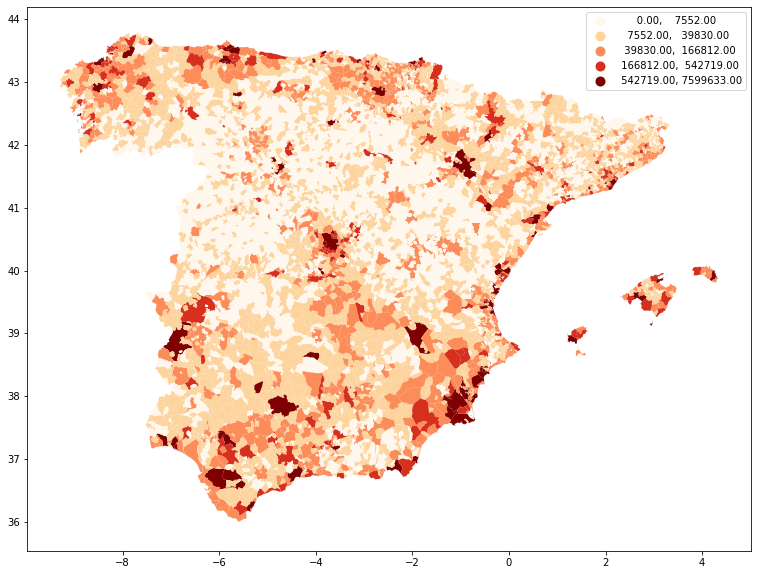

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))

gdf_ghg_municipios.plot(ax=ax, column='co2', cmap='OrRd', scheme='jenkscaspallsampled', legend=True)

**Reorganice OpenGHGMap table**

In [41]:
gdf_ghg_municipios.columns

Index(['NATCODE', 'NAMEUNIT', 'CODNUT1', 'CODNUT2', 'CODNUT3', 'CODIGOINE',
       'geometry', 'categorized', 'rname', 'population_2015', 'co2', 'coco2'],
      dtype='object')

In [43]:
df_ghg = gdf_ghg_municipios.drop(columns=['NATCODE', 'NAMEUNIT', 'CODNUT1', 'CODNUT2', 'CODNUT3', 'geometry', 'rname'])
df_ghg

,CODIGOINE,categorized,population_2015,co2,coco2
0,15001,"{'fuelstations': 13708, 'buildings': 139440, '...",5476.444286,165448.0,319762270.0
1,15002,"{'fuelstations': 13708, 'buildings': 28980, 'f...",26507.657375,43288.0,319762270.0
2,15003,"{'fuelstations': 6854, 'buildings': 56868, 'fa...",1921.967197,64922.0,319762270.0
3,15004,"{'buildings': 64512, 'farms': 20900}",3711.193989,85412.0,319762270.0
4,15005,"{'fuelstations': 41124, 'buildings': 139692, '...",36073.030660,1117753.0,319762270.0
...,...,...,...,...,...
418,23086,"{'fuelstations': 61686, 'buildings': 10752}",13955.039014,72438.0,319762270.0
419,53050,NaN,NaN,NaN,NaN
420,41052,"{'fuelstations': 13708, 'buildings': 420}",3631.199431,14128.0,319762270.0
421,30019,"{'fuelstations': 109664, 'buildings': 7476, 'f...",35384.705255,117240.0,319762270.0


In [49]:
df_ghg = df_ghg.melt(id_vars = ['CODIGOINE'], value_name = "values")
df_ghg['dataset'] = 'OpenGHGMap'
df_ghg.rename(columns={'variable': 'indicator'}, inplace=True)
df_ghg

,CODIGOINE,indicator,values,dataset
0,15001,categorized,"{'fuelstations': 13708, 'buildings': 139440, '...",OpenGHGMap
1,15002,categorized,"{'fuelstations': 13708, 'buildings': 28980, 'f...",OpenGHGMap
2,15003,categorized,"{'fuelstations': 6854, 'buildings': 56868, 'fa...",OpenGHGMap
3,15004,categorized,"{'buildings': 64512, 'farms': 20900}",OpenGHGMap
4,15005,categorized,"{'fuelstations': 41124, 'buildings': 139692, '...",OpenGHGMap
...,...,...,...,...
32455,23086,coco2,319762270.0,OpenGHGMap
32456,53050,coco2,NaN,OpenGHGMap
32457,41052,coco2,319762270.0,OpenGHGMap
32458,30019,coco2,319762270.0,OpenGHGMap


In [52]:
Quitar coco2

,categorized,rname,population_2015,co2,coname,coco2,nrid,geometry
4064,"{'fuelstations': 1782040, 'trains': 10176, 'bu...",Madrid,3.175267e+06,7599633.0,spain,319762270.0,4066,"POLYGON ((-3.57879 40.41830, -3.57953 40.41734..."
